In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines gym-anytrading gym finta

     |████████████████████████████████| 411.5MB 39kB/s 
     |████████████████████████████████| 412.3MB 21kB/s 
     |████████████████████████████████| 245kB 54.2MB/s 
     |████████████████████████████████| 174kB 47.5MB/s 
     |████████████████████████████████| 3.8MB 34.1MB/s 
     |████████████████████████████████| 512kB 41.2MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7557 sha256=2f29f465b1d050b5216e0be70949fc9ac427ac78f65093bace118931751c8696
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.13.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.15.0 which is incompatible.
  Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully un

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv

from finta import TA

from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C
from stable_baselines.common.callbacks import CheckpointCallback, EvalCallback

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/usr/local/lib/python3.7/dist-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [4]:
df = pd.read_csv('gdrive/My Drive/stock/TSLA.csv')

In [5]:
df["Date"] = pd.to_datetime(df["Date"])

In [6]:
df.set_index('Date', inplace=True)

In [7]:
df = df.sort_values(by=["Date"])

In [8]:
df["Volume"] = df["Volume"].astype(float)

In [9]:
df['SMA'] = TA.SMA(df, 10)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)
df.fillna(0, inplace=True)

In [10]:
del df["Adj Close"]

In [11]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

In [12]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals
    
env2 = MyCustomEnv(df=df, window_size=12, frame_bound=(12,50))

In [13]:
eval_callback = EvalCallback(env2, best_model_save_path='gdrive/My Drive/stock/logs1/',
                             log_path='gdrive/My Drive/stock/logs1/', eval_freq=500,
                             deterministic=True, render=False)

In [14]:
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [15]:
model = A2C('MlpLstmPolicy', env, verbose=1) 
model.learn(total_timesteps=100000, callback=eval_callback)





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


---------------------------------
| explained_variance | -0.948   |
| fps                | 18       |
| nupdates           | 1        |
| policy_entropy     | 0.692    |
| total_timesteps    | 5        |
| value_loss         | 0.0411   |
---------------------------------
Eval num_timesteps=500, episode_reward=0.00 +/- 0.00
Episode length: 37.00 +/- 0.00
New best mean reward!
---------------------------------
| explained_variance | -11.8    |
| fps                | 226      |
| nupdates           | 100      |
| policy_entropy     | 0.688    |
| total_timesteps    | 500      |
| value_loss         | 8.29e-05 |
---------------------------

info {'total_reward': -0.2320000000000002, 'total_profit': 0.9371197147651007, 'position': 0}


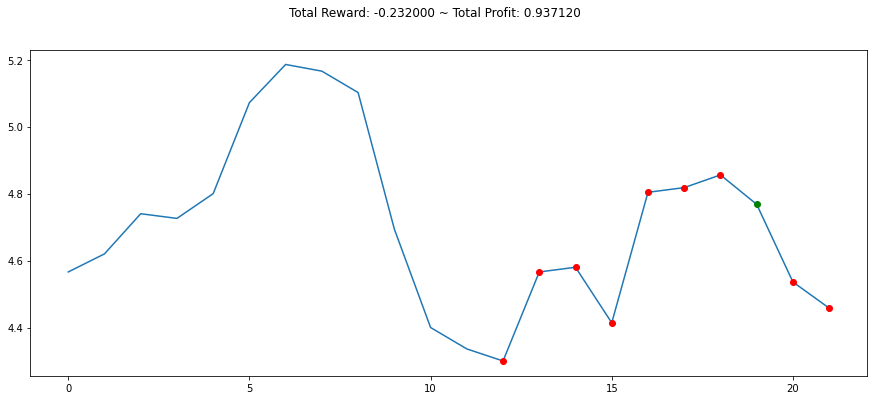

max_possible_profit: 1.1717726894342526


In [17]:
env = MyCustomEnv(df=df, window_size=12, frame_bound=(290,300))
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

print("max_possible_profit:", env.max_possible_profit())

info {'total_reward': -0.6660050000000126, 'total_profit': 0.9008339348373208, 'position': 0}


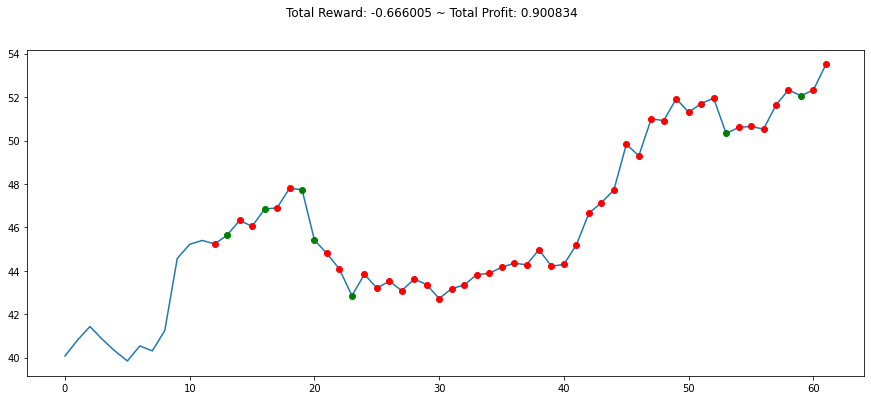

max_possible_profit: 1.5082253936858805


In [18]:
env = MyCustomEnv(df=df, window_size=12, frame_bound=(1000,1050))
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

print("max_possible_profit:", env.max_possible_profit())

info {'total_reward': -2.1659879999999774, 'total_profit': 0.7509717232503272, 'position': 0}


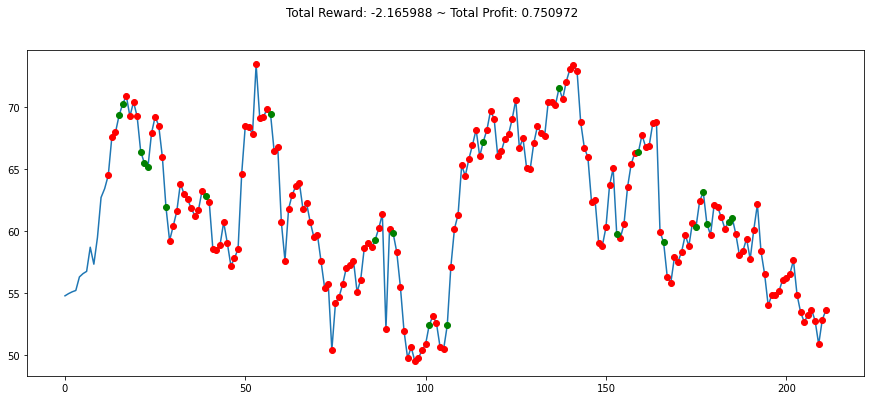

max_possible_profit: 12.135769113805964


In [19]:
env = MyCustomEnv(df=df, window_size=12, frame_bound=(2000,2200))
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

print("max_possible_profit:", env.max_possible_profit())

info {'total_reward': -0.3080000000000007, 'total_profit': 0.8949251006983348, 'position': 1}


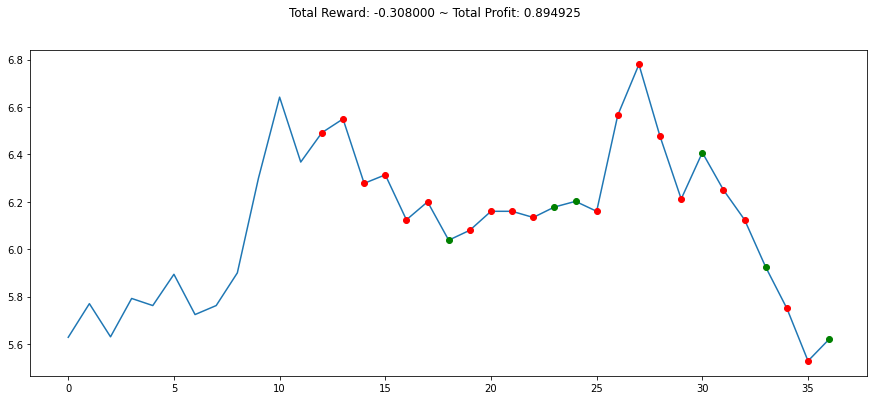

max_possible_profit: 1.2469870162443977


In [20]:
env = MyCustomEnv(df=df, window_size=12, frame_bound=(500,525))
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

print("max_possible_profit:", env.max_possible_profit())